In [22]:
%matplotlib inline
import os, random, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.datasets as dset
import torchvision.transforms.functional as TF
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from utils.constants import *
from utils.data import ImageTransform, MonetDataset, MonetDataModule
from utils.model import Generator, Discriminator
from utils.lightning import LightningSystem

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [23]:
# Check input
transform = ImageTransform(img_size=256)
batch_size = 8

dm = MonetDataModule(data_dir, transform, batch_size, phase='test')
dm.prepare_data()

dataloader = dm.train_dataloader()
base, style = next(iter(dataloader))

print('Input Shape {}, {}'.format(base.size(), style.size()))


Input Shape torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])


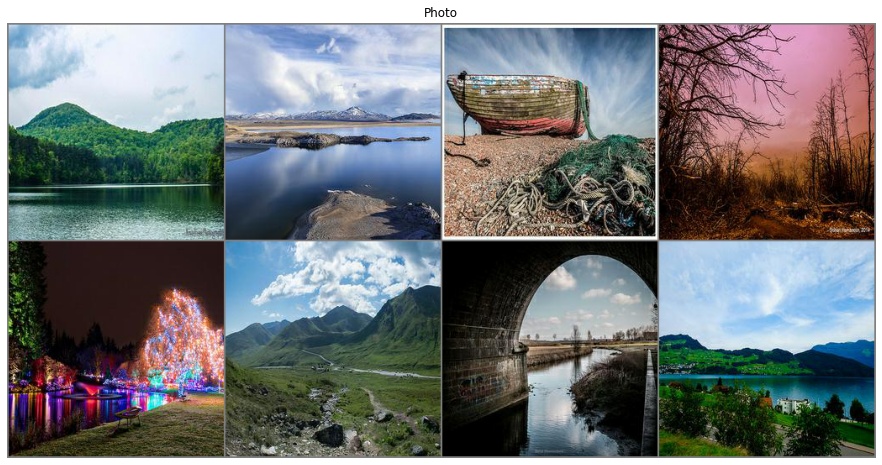

In [16]:
# Show photos

temp = make_grid(base, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Photo')
plt.show()

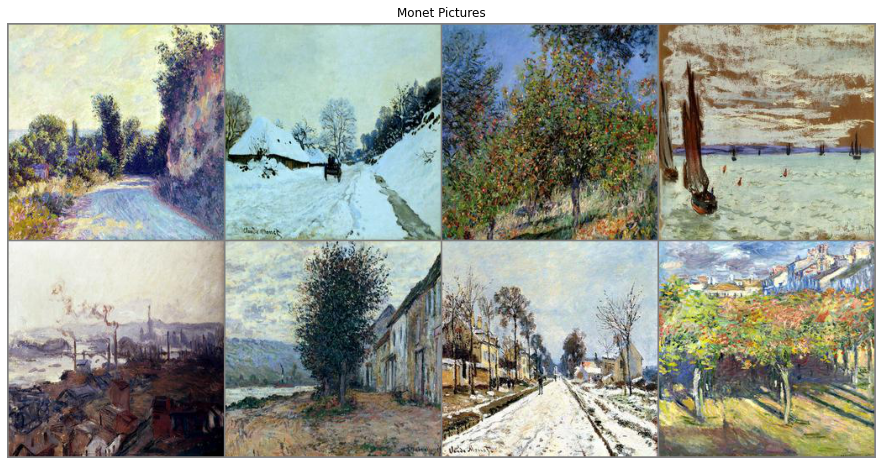

In [17]:
# Show Monet paintings

temp = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Monet Pictures')
plt.show()


In [18]:
# Sanity check Generator and Discriminator

net = Generator()
out = net(base)
print('Generator:', out.size())

net = Discriminator()
out = net(base)
print('Discriminator:', out.size())


Generator: torch.Size([8, 3, 256, 256])
Discriminator: torch.Size([8, 1, 30, 30])


In [19]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>

In [ ]:
# Train

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

for i in range(30):
    # Config
    seed = 42
    reconstr_w = 10
    id_w = 5
    seed_everything(seed)

    # DataModule
    dm = MonetDataModule(data_dir, transform, batch_size, seed=seed)

    G_basestyle = Generator().to(device)
    G_stylebase = Generator().to(device)
    D_base = Discriminator().to(device)
    D_style = Discriminator().to(device)

    # Init Weight
    for net in [G_basestyle, G_stylebase, D_base, D_style]:
        init_weights(net, init_type='normal')

    # Transform images
    transform = ImageTransform(img_size=image_size)

    # LightningModule
    model = LightningSystem(G_basestyle, G_stylebase, D_base, D_style, 
                                 lr, transform, reconstr_w, id_w, num_epochs)
    if (os.path.exists('./saved_models/model')):
        print("Using previous model. Resuming training.")
        model.load_state_dict(torch.load('./saved_models/model'))

    print("Number of epochs:" + str(num_epochs))

    # Trainer
    trainer = Trainer(
        logger=False,
        max_epochs=num_epochs,
        gpus=ngpu,
        checkpoint_callback=False,
        reload_dataloaders_every_epoch=True,
        num_sanity_val_steps=0,  # Skip Sanity Check
    )

    # Train
    trainer.fit(model, datamodule=dm)

    # Save model
    torch.save(model.state_dict(), './saved_models/model')

Losses log for CycleGAN

Using previous model. Resuming training.


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2739

[0/1][0] 	Loss_G: 1.7322

[0/1][0] 	Loss_val: 0.2734

[0/1][0] 	Loss_G: 1.7092

[0/1][0]	Loss_D: 0.2122

[0/1][1]	Loss_D: 0.5082

[0/1][2] 	Loss_val: 1.0188

[0/1][2] 	Loss_G: 2.7292

[0/1][2] 	Loss_val: 0.9824

[0/1][2] 	Loss_G: 2.6745

[0/1][2]	Loss_D: 0.9827

[0/1][3]	Loss_D: 0.6774

[0/1][4] 	Loss_val: 0.4177

[0/1][4] 	Loss_G: 1.8834

[0/1][4] 	Loss_val: 0.4187

[0/1][4] 	Loss_G: 1.8126

[0/1][4]	Loss_D: 0.4460

[0/1][5]	Loss_D: 0.5398

[0/1][6] 	Loss_val: 0.5493

[0/1][6] 	Loss_G: 2.0737

[0/1][6] 	Loss_val: 0.5489

[0/1][6] 	Loss_G: 2.0196

[0/1][6]	Loss_D: 0.3178

[0/1][7]	Loss_D: 0.2543

[0/1][8] 	Loss_val: 0.4138

[0/1][8] 	Loss_G: 1.9780

[0/1][8] 	Loss_val: 0.4111

[0/1][8] 	Loss_G: 1.9401

[0/1][8]	Loss_D: 0.2400

[0/1][9]	Loss_D: 0.1959

[0/1][10] 	Loss_val: 0.1988

[0/1][10] 	Loss_G: 1.7705

[0/1][10] 	Loss_val: 0.2009

[0/1][10] 	Loss_G: 1.7145

[0/1][10]	Loss_D: 0.2143

[0/1][11]	Loss_D: 0.2159

[0/1][12] 	Loss_val: 0.1912

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.3164

[0/1][0] 	Loss_G: 1.8426

[0/1][0] 	Loss_val: 0.2919

[0/1][0] 	Loss_G: 1.7876

[0/1][0]	Loss_D: 0.2166

[0/1][1]	Loss_D: 0.7672

[0/1][2] 	Loss_val: 1.2979

[0/1][2] 	Loss_G: 2.7482

[0/1][2] 	Loss_val: 1.2389

[0/1][2] 	Loss_G: 2.6831

[0/1][2]	Loss_D: 0.8851

[0/1][3]	Loss_D: 0.3727

[0/1][4] 	Loss_val: 0.2654

[0/1][4] 	Loss_G: 1.6412

[0/1][4] 	Loss_val: 0.2707

[0/1][4] 	Loss_G: 1.6017

[0/1][4]	Loss_D: 0.2721

[0/1][5]	Loss_D: 0.3925

[0/1][6] 	Loss_val: 0.3418

[0/1][6] 	Loss_G: 1.8220

[0/1][6] 	Loss_val: 0.3447

[0/1][6] 	Loss_G: 1.7887

[0/1][6]	Loss_D: 0.3808

[0/1][7]	Loss_D: 0.2647

[0/1][8] 	Loss_val: 0.2836

[0/1][8] 	Loss_G: 1.8187

[0/1][8] 	Loss_val: 0.2797

[0/1][8] 	Loss_G: 1.7869

[0/1][8]	Loss_D: 0.2935

[0/1][9]	Loss_D: 0.2909

[0/1][10] 	Loss_val: 0.3367

[0/1][10] 	Loss_G: 1.9308

[0/1][10] 	Loss_val: 0.3370

[0/1][10] 	Loss_G: 1.8927

[0/1][10]	Loss_D: 0.2539

[0/1][11]	Loss_D: 0.2207

[0/1][12] 	Loss_val: 0.2448

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2584

[0/1][0] 	Loss_G: 1.7072

[0/1][0] 	Loss_val: 0.2439

[0/1][0] 	Loss_G: 1.7097

[0/1][0]	Loss_D: 0.2208

[0/1][1]	Loss_D: 0.7110

[0/1][2] 	Loss_val: 1.1060

[0/1][2] 	Loss_G: 2.5602

[0/1][2] 	Loss_val: 1.0716

[0/1][2] 	Loss_G: 2.5162

[0/1][2]	Loss_D: 0.9420

[0/1][3]	Loss_D: 0.5086

[0/1][4] 	Loss_val: 0.1531

[0/1][4] 	Loss_G: 1.5689

[0/1][4] 	Loss_val: 0.1614

[0/1][4] 	Loss_G: 1.5193

[0/1][4]	Loss_D: 0.2674

[0/1][5]	Loss_D: 0.3731

[0/1][6] 	Loss_val: 0.3525

[0/1][6] 	Loss_G: 1.6934

[0/1][6] 	Loss_val: 0.3554

[0/1][6] 	Loss_G: 1.6590

[0/1][6]	Loss_D: 0.3623

[0/1][7]	Loss_D: 0.2604

[0/1][8] 	Loss_val: 0.2137

[0/1][8] 	Loss_G: 1.7268

[0/1][8] 	Loss_val: 0.2152

[0/1][8] 	Loss_G: 1.6888

[0/1][8]	Loss_D: 0.2355

[0/1][9]	Loss_D: 0.2417

[0/1][10] 	Loss_val: 0.4210

[0/1][10] 	Loss_G: 1.6661

[0/1][10] 	Loss_val: 0.4092

[0/1][10] 	Loss_G: 1.6496

[0/1][10]	Loss_D: 0.1977

[0/1][11]	Loss_D: 0.1788

[0/1][12] 	Loss_val: 0.2117

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.3776

[0/1][0] 	Loss_G: 1.8680

[0/1][0] 	Loss_val: 0.3536

[0/1][0] 	Loss_G: 1.8510

[0/1][0]	Loss_D: 0.2279

[0/1][1]	Loss_D: 0.7085

[0/1][2] 	Loss_val: 1.1743

[0/1][2] 	Loss_G: 2.4504

[0/1][2] 	Loss_val: 1.1630

[0/1][2] 	Loss_G: 2.3753

[0/1][2]	Loss_D: 1.1974

[0/1][3]	Loss_D: 0.7409

[0/1][4] 	Loss_val: 0.2822

[0/1][4] 	Loss_G: 1.6036

[0/1][4] 	Loss_val: 0.2899

[0/1][4] 	Loss_G: 1.5678

[0/1][4]	Loss_D: 0.2016

[0/1][5]	Loss_D: 0.3062

[0/1][6] 	Loss_val: 0.4633

[0/1][6] 	Loss_G: 1.8686

[0/1][6] 	Loss_val: 0.4666

[0/1][6] 	Loss_G: 1.8294

[0/1][6]	Loss_D: 0.4793

[0/1][7]	Loss_D: 0.3715

[0/1][8] 	Loss_val: 0.2709

[0/1][8] 	Loss_G: 1.6761

[0/1][8] 	Loss_val: 0.2646

[0/1][8] 	Loss_G: 1.6426

[0/1][8]	Loss_D: 0.2278

[0/1][9]	Loss_D: 0.2277

[0/1][10] 	Loss_val: 0.3683

[0/1][10] 	Loss_G: 1.5849

[0/1][10] 	Loss_val: 0.3545

[0/1][10] 	Loss_G: 1.5594

[0/1][10]	Loss_D: 0.1994

[0/1][11]	Loss_D: 0.1772

[0/1][12] 	Loss_val: 0.3246

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2524

[0/1][0] 	Loss_G: 1.7821

[0/1][0] 	Loss_val: 0.2436

[0/1][0] 	Loss_G: 1.7685

[0/1][0]	Loss_D: 0.2276

[0/1][1]	Loss_D: 0.4040

[0/1][2] 	Loss_val: 0.7023

[0/1][2] 	Loss_G: 2.1255

[0/1][2] 	Loss_val: 0.7077

[0/1][2] 	Loss_G: 2.0790

[0/1][2]	Loss_D: 0.8818

[0/1][3]	Loss_D: 0.7174

[0/1][4] 	Loss_val: 0.3193

[0/1][4] 	Loss_G: 1.7942

[0/1][4] 	Loss_val: 0.3223

[0/1][4] 	Loss_G: 1.7409

[0/1][4]	Loss_D: 0.2018

[0/1][5]	Loss_D: 0.3035

[0/1][6] 	Loss_val: 0.5616

[0/1][6] 	Loss_G: 1.9172

[0/1][6] 	Loss_val: 0.5618

[0/1][6] 	Loss_G: 1.8761

[0/1][6]	Loss_D: 0.4642

[0/1][7]	Loss_D: 0.3454

[0/1][8] 	Loss_val: 0.2998

[0/1][8] 	Loss_G: 1.6357

[0/1][8] 	Loss_val: 0.2843

[0/1][8] 	Loss_G: 1.6113

[0/1][8]	Loss_D: 0.2351

[0/1][9]	Loss_D: 0.2336

[0/1][10] 	Loss_val: 0.3078

[0/1][10] 	Loss_G: 1.4252

[0/1][10] 	Loss_val: 0.3018

[0/1][10] 	Loss_G: 1.4034

[0/1][10]	Loss_D: 0.2140

[0/1][11]	Loss_D: 0.2072

[0/1][12] 	Loss_val: 0.2437

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Number of epochs:1



  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.3456

[0/1][0] 	Loss_G: 1.4733

[0/1][0] 	Loss_val: 0.3667

[0/1][0] 	Loss_G: 1.4626

[0/1][0]	Loss_D: 0.2466

[0/1][1]	Loss_D: 0.5325

[0/1][2] 	Loss_val: 1.0817

[0/1][2] 	Loss_G: 2.4895

[0/1][2] 	Loss_val: 1.0713

[0/1][2] 	Loss_G: 2.4491

[0/1][2]	Loss_D: 1.0069

[0/1][3]	Loss_D: 0.6453

[0/1][4] 	Loss_val: 0.3335

[0/1][4] 	Loss_G: 1.5917

[0/1][4] 	Loss_val: 0.2966

[0/1][4] 	Loss_G: 1.5445

[0/1][4]	Loss_D: 0.1678

[0/1][5]	Loss_D: 0.2483

[0/1][6] 	Loss_val: 0.5453

[0/1][6] 	Loss_G: 1.8233

[0/1][6] 	Loss_val: 0.5198

[0/1][6] 	Loss_G: 1.7721

[0/1][6]	Loss_D: 0.3925

[0/1][7]	Loss_D: 0.3111

[0/1][8] 	Loss_val: 0.3371

[0/1][8] 	Loss_G: 1.6093

[0/1][8] 	Loss_val: 0.3333

[0/1][8] 	Loss_G: 1.5841

[0/1][8]	Loss_D: 0.1696

[0/1][9]	Loss_D: 0.1710

[0/1][10] 	Loss_val: 0.3389

[0/1][10] 	Loss_G: 1.7585

[0/1][10] 	Loss_val: 0.3397

[0/1][10] 	Loss_G: 1.7258

[0/1][10]	Loss_D: 0.2127

[0/1][11]	Loss_D: 0.1980

[0/1][12] 	Loss_val: 0.2090

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Number of epochs:1


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.4582

[0/1][0] 	Loss_G: 1.5346

[0/1][0] 	Loss_val: 0.3901

[0/1][0] 	Loss_G: 1.4950

[0/1][0]	Loss_D: 0.1614

[0/1][1]	Loss_D: 0.5909

[0/1][2] 	Loss_val: 1.1276

[0/1][2] 	Loss_G: 2.4199

[0/1][2] 	Loss_val: 1.1041

[0/1][2] 	Loss_G: 2.3794

[0/1][2]	Loss_D: 1.1488

[0/1][3]	Loss_D: 0.7351

[0/1][4] 	Loss_val: 0.2694

[0/1][4] 	Loss_G: 1.6391

[0/1][4] 	Loss_val: 0.2551

[0/1][4] 	Loss_G: 1.6234

[0/1][4]	Loss_D: 0.2070

[0/1][5]	Loss_D: 0.3069

[0/1][6] 	Loss_val: 0.4711

[0/1][6] 	Loss_G: 1.7696

[0/1][6] 	Loss_val: 0.4888

[0/1][6] 	Loss_G: 1.7537

[0/1][6]	Loss_D: 0.4044

[0/1][7]	Loss_D: 0.3046

[0/1][8] 	Loss_val: 0.3115

[0/1][8] 	Loss_G: 1.5350

[0/1][8] 	Loss_val: 0.3132

[0/1][8] 	Loss_G: 1.5064

[0/1][8]	Loss_D: 0.2265

[0/1][9]	Loss_D: 0.2292

[0/1][10] 	Loss_val: 0.3521

[0/1][10] 	Loss_G: 1.6644

[0/1][10] 	Loss_val: 0.3530

[0/1][10] 	Loss_G: 1.6230

[0/1][10]	Loss_D: 0.2467

[0/1][11]	Loss_D: 0.2184

[0/1][12] 	Loss_val: 0.2881

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Number of epochs:1



  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2233

[0/1][0] 	Loss_G: 1.5445

[0/1][0] 	Loss_val: 0.2049

[0/1][0] 	Loss_G: 1.5288

[0/1][0]	Loss_D: 0.2683

[0/1][1]	Loss_D: 0.6507

[0/1][2] 	Loss_val: 1.1207

[0/1][2] 	Loss_G: 2.4485

[0/1][2] 	Loss_val: 1.0797

[0/1][2] 	Loss_G: 2.3705

[0/1][2]	Loss_D: 1.0811

[0/1][3]	Loss_D: 0.7043

[0/1][4] 	Loss_val: 0.3014

[0/1][4] 	Loss_G: 1.5689

[0/1][4] 	Loss_val: 0.3262

[0/1][4] 	Loss_G: 1.5624

[0/1][4]	Loss_D: 0.1699

[0/1][5]	Loss_D: 0.2427

[0/1][6] 	Loss_val: 0.4999

[0/1][6] 	Loss_G: 1.7031

[0/1][6] 	Loss_val: 0.5073

[0/1][6] 	Loss_G: 1.6680

[0/1][6]	Loss_D: 0.4136

[0/1][7]	Loss_D: 0.3165

[0/1][8] 	Loss_val: 0.3118

[0/1][8] 	Loss_G: 1.5454

[0/1][8] 	Loss_val: 0.2863

[0/1][8] 	Loss_G: 1.4939

[0/1][8]	Loss_D: 0.1731

[0/1][9]	Loss_D: 0.1878

[0/1][10] 	Loss_val: 0.3420

[0/1][10] 	Loss_G: 1.7182

[0/1][10] 	Loss_val: 0.3209

[0/1][10] 	Loss_G: 1.6812

[0/1][10]	Loss_D: 0.2318

[0/1][11]	Loss_D: 0.2109

[0/1][12] 	Loss_val: 0.2119

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2566

[0/1][0] 	Loss_G: 1.5668

[0/1][0] 	Loss_val: 0.2582

[0/1][0] 	Loss_G: 1.5529

[0/1][0]	Loss_D: 0.2373

[0/1][1]	Loss_D: 0.4152

[0/1][2] 	Loss_val: 0.5783

[0/1][2] 	Loss_G: 1.6714

[0/1][2] 	Loss_val: 0.5669

[0/1][2] 	Loss_G: 1.6367

[0/1][2]	Loss_D: 0.7225

[0/1][3]	Loss_D: 0.5681

[0/1][4] 	Loss_val: 0.3286

[0/1][4] 	Loss_G: 1.4530

[0/1][4] 	Loss_val: 0.3284

[0/1][4] 	Loss_G: 1.4150

[0/1][4]	Loss_D: 0.2259

[0/1][5]	Loss_D: 0.2362

[0/1][6] 	Loss_val: 0.4637

[0/1][6] 	Loss_G: 1.6077

[0/1][6] 	Loss_val: 0.4547

[0/1][6] 	Loss_G: 1.5862

[0/1][6]	Loss_D: 0.3513

[0/1][7]	Loss_D: 0.3189

[0/1][8] 	Loss_val: 0.3342

[0/1][8] 	Loss_G: 1.4250

[0/1][8] 	Loss_val: 0.3222

[0/1][8] 	Loss_G: 1.3834

[0/1][8]	Loss_D: 0.1882

[0/1][9]	Loss_D: 0.1706

[0/1][10] 	Loss_val: 0.2257

[0/1][10] 	Loss_G: 1.4448

[0/1][10] 	Loss_val: 0.2379

[0/1][10] 	Loss_G: 1.4025

[0/1][10]	Loss_D: 0.2170

[0/1][11]	Loss_D: 0.2193

[0/1][12] 	Loss_val: 0.2539

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.5259

[0/1][0] 	Loss_G: 1.8444

[0/1][0] 	Loss_val: 0.5021

[0/1][0] 	Loss_G: 1.7986

[0/1][0]	Loss_D: 0.1354

[0/1][1]	Loss_D: 0.4871

[0/1][2] 	Loss_val: 1.1942

[0/1][2] 	Loss_G: 2.5105

[0/1][2] 	Loss_val: 1.2357

[0/1][2] 	Loss_G: 2.4227

[0/1][2]	Loss_D: 0.7662

[0/1][3]	Loss_D: 0.4097

[0/1][4] 	Loss_val: 0.4935

[0/1][4] 	Loss_G: 1.6188

[0/1][4] 	Loss_val: 0.4835

[0/1][4] 	Loss_G: 1.5891

[0/1][4]	Loss_D: 0.3368

[0/1][5]	Loss_D: 0.4117

[0/1][6] 	Loss_val: 0.4008

[0/1][6] 	Loss_G: 1.5584

[0/1][6] 	Loss_val: 0.3948

[0/1][6] 	Loss_G: 1.5258

[0/1][6]	Loss_D: 0.2931

[0/1][7]	Loss_D: 0.2234

[0/1][8] 	Loss_val: 0.3149

[0/1][8] 	Loss_G: 1.4267

[0/1][8] 	Loss_val: 0.3026

[0/1][8] 	Loss_G: 1.3907

[0/1][8]	Loss_D: 0.1861

[0/1][9]	Loss_D: 0.1851

[0/1][10] 	Loss_val: 0.2504

[0/1][10] 	Loss_G: 1.6210

[0/1][10] 	Loss_val: 0.2574

[0/1][10] 	Loss_G: 1.5976

[0/1][10]	Loss_D: 0.2372

[0/1][11]	Loss_D: 0.2205

[0/1][12] 	Loss_val: 0.3513

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[0/1][0] 	Loss_val: 0.2202

[0/1][0] 	Loss_G: 1.6462

[0/1][0] 	Loss_val: 0.1912

[0/1][0] 	Loss_G: 1.6139

[0/1][0]	Loss_D: 0.2075

[0/1][1]	Loss_D: 0.5824

[0/1][2] 	Loss_val: 1.3403

[0/1][2] 	Loss_G: 2.4843

[0/1][2] 	Loss_val: 1.2733

[0/1][2] 	Loss_G: 2.4264

[0/1][2]	Loss_D: 1.0586

[0/1][3]	Loss_D: 0.6694

[0/1][4] 	Loss_val: 0.2879

[0/1][4] 	Loss_G: 1.4944

[0/1][4] 	Loss_val: 0.2983

[0/1][4] 	Loss_G: 1.4536

[0/1][4]	Loss_D: 0.1892

[0/1][5]	Loss_D: 0.2708

[0/1][6] 	Loss_val: 0.4551

[0/1][6] 	Loss_G: 1.5722

[0/1][6] 	Loss_val: 0.4536

[0/1][6] 	Loss_G: 1.5392

[0/1][6]	Loss_D: 0.4158

[0/1][7]	Loss_D: 0.3277

[0/1][8] 	Loss_val: 0.3081

[0/1][8] 	Loss_G: 1.4847

[0/1][8] 	Loss_val: 0.3077

[0/1][8] 	Loss_G: 1.4565

[0/1][8]	Loss_D: 0.1962

[0/1][9]	Loss_D: 0.1951

[0/1][10] 	Loss_val: 0.3304

[0/1][10] 	Loss_G: 1.4636

[0/1][10] 	Loss_val: 0.3471

[0/1][10] 	Loss_G: 1.4477

[0/1][10]	Loss_D: 0.1976

[0/1][11]	Loss_D: 0.1711

[0/1][12] 	Loss_val: 0.2807

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:01, ?it/s]

[0/1][0] 	Loss_val: 0.2782

[0/1][0] 	Loss_G: 1.3980

[0/1][0] 	Loss_val: 0.3192

[0/1][0] 	Loss_G: 1.4089

[0/1][0]	Loss_D: 0.1614

[0/1][1]	Loss_D: 0.5826

[0/1][2] 	Loss_val: 1.2173

[0/1][2] 	Loss_G: 2.3491

[0/1][2] 	Loss_val: 1.1939

[0/1][2] 	Loss_G: 2.2762

[0/1][2]	Loss_D: 0.8189

[0/1][3]	Loss_D: 0.4238

[0/1][4] 	Loss_val: 0.5754

[0/1][4] 	Loss_G: 1.6338

[0/1][4] 	Loss_val: 0.5212

[0/1][4] 	Loss_G: 1.5545

[0/1][4]	Loss_D: 0.2356

[0/1][5]	Loss_D: 0.3212

[0/1][6] 	Loss_val: 0.4001

[0/1][6] 	Loss_G: 1.4006

[0/1][6] 	Loss_val: 0.3798

[0/1][6] 	Loss_G: 1.3741

[0/1][6]	Loss_D: 0.2901

[0/1][7]	Loss_D: 0.1884

[0/1][8] 	Loss_val: 0.2770

[0/1][8] 	Loss_G: 1.3814

[0/1][8] 	Loss_val: 0.2612

[0/1][8] 	Loss_G: 1.3658

[0/1][8]	Loss_D: 0.2038

[0/1][9]	Loss_D: 0.2132

[0/1][10] 	Loss_val: 0.2199

[0/1][10] 	Loss_G: 1.3879

[0/1][10] 	Loss_val: 0.2304

[0/1][10] 	Loss_G: 1.3597

[0/1][10]	Loss_D: 0.2742

[0/1][11]	Loss_D: 0.2460

[0/1][12] 	Loss_val: 0.2708

[0/1][12] 	Loss_G

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name               | Type          | Params
-----------------------------------------------------
0 | G_basestyle        | Generator     | 16.7 M
1 | G_stylebase        | Generator     | 16.7 M
2 | D_base             | Discriminator | 2.8 M 
3 | D_style            | Discriminator | 2.8 M 
4 | mae                | L1Loss        | 0     
5 | generator_loss     | MSELoss       | 0     
6 | discriminator_loss | MSELoss       | 0     
-----------------------------------------------------
38.8 M    Trainable params
0         Non-trainable params
38.8 M    Total params
155.380   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [20]:
def seed_everything_notrain(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
# Config
seed = 42
reconstr_w = 10
id_w = 5
seed_everything_notrain(seed)
    
# DataModule
dm = MonetDataModule(data_dir, transform, batch_size, seed=seed)
G_basestyle = Generator().to(device)
G_stylebase = Generator().to(device)
D_base = Discriminator().to(device)
D_style = Discriminator().to(device)

# Init Weight
for net in [G_basestyle, G_stylebase, D_base, D_style]:
    init_weights(net, init_type='normal')

# Transform images
transform = ImageTransform(img_size=image_size)

# LightningModule
model = LightningSystem(G_basestyle, G_stylebase, D_base, D_style, 
                                 lr, transform, reconstr_w, id_w, num_epochs)
if (os.path.exists('./saved_models/model')):
        print("Using previous model.")
        model.load_state_dict(torch.load('./saved_models/model'))

Losses log for CycleGAN

Using previous model.


[]


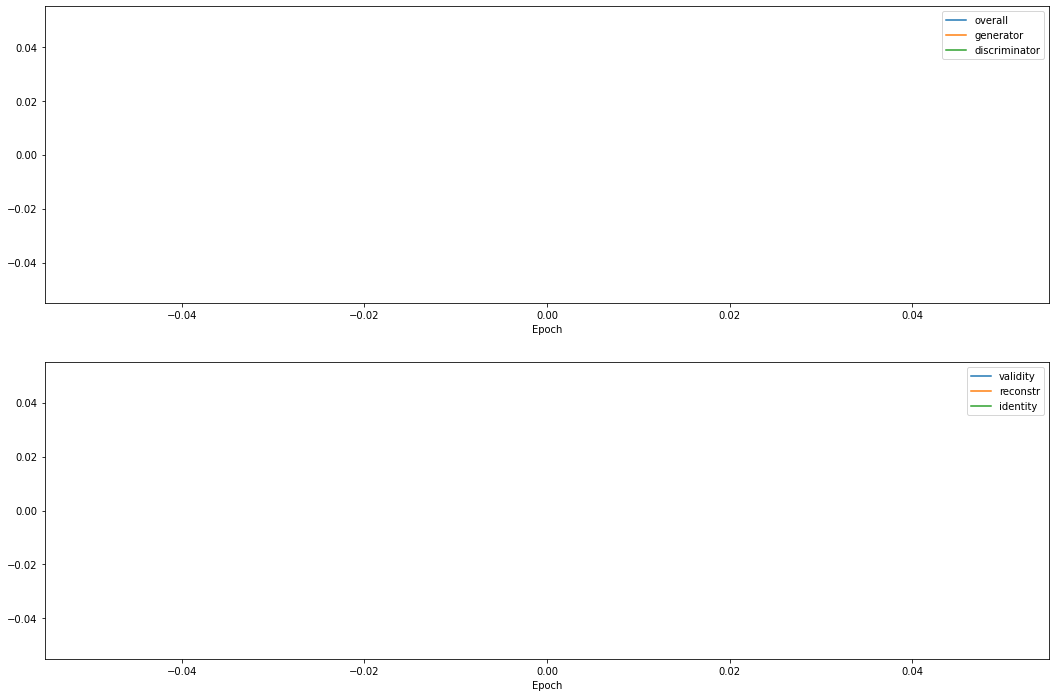

In [26]:
# Loss Plot
# TODO: scrape data? need to plot over 21 epochs
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(18, 12), facecolor='w')
epoch_num = len(model.losses)

print(model.losses)

axes[0].plot(np.arange(epoch_num), model.losses, label='overall')
axes[0].plot(np.arange(epoch_num), model.G_mean_losses, label='generator')
axes[0].plot(np.arange(epoch_num), model.D_mean_losses, label='discriminator')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(np.arange(epoch_num), model.validity, label='validity')
axes[1].plot(np.arange(epoch_num), model.reconstr, label='reconstr')
axes[1].plot(np.arange(epoch_num), model.identity, label='identity')
axes[1].legend()
axes[1].set_xlabel('Epoch')

plt.show()

In [24]:
# Evaluate on photos and save results

os.makedirs('./results', exist_ok=True)
net = model.G_basestyle

net.eval()
photo_img_paths = glob(os.path.join(data_dir, 'photo', '*.jpg'))

for path in photo_img_paths:
    photo_id = path.split('/')[-1]
    img = transform(Image.open(path), phase='test')
    
    gen_img = net(img.unsqueeze(0).to(device))[0]
    
    # Reverse Normalization
    gen_img = gen_img * 0.5 + 0.5
    gen_img = gen_img * 255
    gen_img = gen_img.detach().cpu().numpy().astype(np.uint8)
    
    gen_img = np.transpose(gen_img, [1,2,0])
    
    gen_img = Image.fromarray(gen_img)
    gen_img.save(os.path.join('./results', photo_id))

KeyboardInterrupt: 